In [1]:
import sys
sys.path.append("../src")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import umap

from lib.i_o import read_csv

In [2]:
df_x_train = read_csv("X_train.csv", "../data/")
df_y_train = read_csv("y_train.csv", "../data/")

Read data from ../data/X_train.csv
Read data from ../data/y_train.csv


In [3]:
print(f"#Features: {df_x_train.shape[1]}\n#observations: {df_x_train.shape[0]}")

#Features: 833
#observations: 1212


In [4]:
# df_y_train.set_index('id', inplace=True)
# df_x_train.set_index('id', inplace=True)

In [5]:
from sklearn import preprocessing
df_impute_before = df_x_train.drop(columns='id')
scaler = preprocessing.RobustScaler().fit(df_impute_before)
df_impute_before = pd.DataFrame(scaler.transform(df_impute_before))

In [6]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

if 'id' in df_impute_before.columns: 
    df_impute_before = df_impute_before.drop(columns='id')

imp = KNNImputer(missing_values=np.nan, weights="distance")
imp.fit(df_impute_before)
df_x_train_imputed = pd.DataFrame(imp.transform(df_impute_before))

In [7]:
reducer = umap.UMAP(n_neighbors=10)
embedding = reducer.fit_transform(df_x_train_imputed)
df_embedding = pd.DataFrame(embedding)

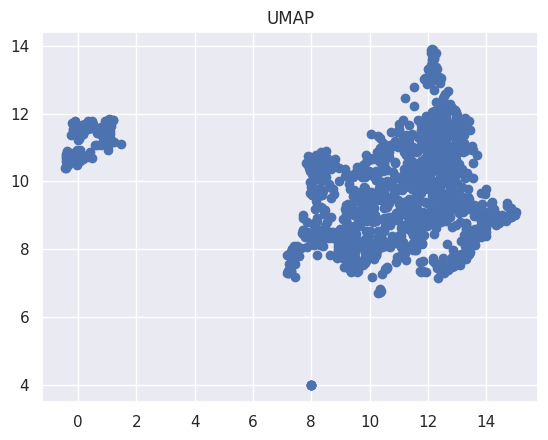

In [8]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('UMAP');

In [9]:
try: 
    prev_labels = clf.labels_
except: 
    prev_labels = np.array([])
    print("No previous outliers computed")

No previous outliers computed


In [10]:
# Detect out / inliers
from pyod.models.knn import KNN
from pyod.models.kde import KDE
from pyod.models.inne import INNE
clf = INNE(n_estimators=300)
X = np.array(embedding)
clf.fit(X)
pd.Series(clf.labels_).value_counts()

0    1090
1     122
dtype: int64

In [11]:
print(f"Outliers are unchanged: {np.array_equal(prev_labels, clf.labels_)}")

Outliers are unchanged: False


In [12]:
# Join out / inlier column
df_embedding["is_inlier"] = clf.labels_ == 0
df_x_train_imputed['is_inlier'] = clf.labels_ == 0
df_x_train_imputed['is_inlier'].value_counts()

True     1090
False     122
Name: is_inlier, dtype: int64

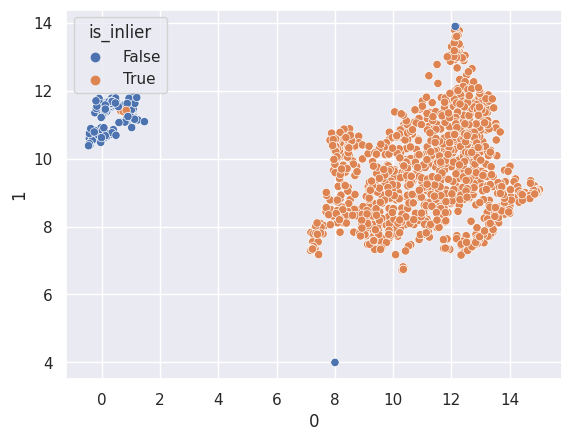

In [13]:
import seaborn as sns 
sns.scatterplot(x=0, y=1, data=df_embedding, hue='is_inlier');

In [14]:
# Join y column
df_x_train_imputed['id'] = df_x_train['id']
if 'y' not in df_x_train_imputed.columns: 
    df_x_train_imputed = df_x_train_imputed.merge(df_y_train, how='left', left_on='id', right_on='id')

In [15]:
# Remove outliers
# df_x_train_inliers = df_x_train_imputed[df_x_train_imputed['is_inlier']].drop(columns=['id', 'is_inlier'])
df_x_train_inliers = df_x_train_imputed.drop(columns=['id', 'is_inlier'])

In [16]:
from sklearn.model_selection import train_test_split

# Prepare data for splitting
X = df_x_train_inliers.drop(columns='y')
y = df_x_train_inliers['y']

scaler = preprocessing.RobustScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1) 

In [17]:
# Standardize features
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_val_scaled = scaler.transform(X_val)

In [ ]:
# Train regression model
from sklearn import linear_model
from sklearn.linear_model import LassoCV
reg_model = LassoCV(cv=20, random_state=92, n_jobs=-1, selection="random", max_iter=30000)
# reg_model = linear_model.Lasso(alpha=0.4, random_state=92, selection="random", max_iter=10000) # 0.45
reg = reg_model.fit(X_train, y_train)

In [ ]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LinearRegression

# model = SelectFromModel(reg_model, prefit=True)
# X_train_selected = model.transform(X_train_scaled)
# X_val_selected = model.transform(X_val_scaled)
# reg_model_selected = LinearRegression().fit(X_train_selected, y_train)

In [ ]:
coeffs = pd.Series(reg_model.coef_)
print(coeffs.describe(), end='\n\n')

print("-----------------------------------")
print(f"# non zero coefficients {(coeffs != 0).sum()}")
# print(f"Alpha {round(reg.alpha_, 3)}")

In [ ]:
# Non zero coefficients
coeffs[(coeffs != 0)]

In [ ]:
# Make predictions
try:
    train_pred_previous = np.array(train_pred, copy=True)
except: 
    print("train_pred is not defined, probably")
    train_pred_previous = np.array([])


train_pred = reg.predict(X_train)
print(f"Training predictions unchanged: {np.array_equal(train_pred, train_pred_previous)}")
val_pred = reg.predict(X_val)
# train_pred_selected = reg_model_selected.predict(X_train_selected)
# val_pred_selected = reg_model_selected.predict(X_val_selected)

In [ ]:
validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}")

Training score 0.44  
Test score 0.505

In [ ]:
sns.boxplot(x=(y_train - train_pred))

In [ ]:
sns.boxplot(x=(y_val - val_pred))